In [341]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import sys
print("Python version: {}". format(sys.version))
print("pandas version: {}". format(pd.__version__))
import matplotlib
import matplotlib.pyplot as plt
print("matplotlib version: {}". format(matplotlib.__version__))
import seaborn as sns
print("numpy version: {}". format(np.__version__))
import sklearn
print("sklearn version: {}". format(sklearn.__version__))
#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics, svm
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
import keras.api._v2.keras as keras
import tensorflow as tf
from keras.layers import Dense, Input, BatchNormalization, Dropout
from keras import Sequential
from keras import utils
from keras.activations import sigmoid
from xgboost import XGBRegressor
le = LabelEncoder()

print('-'*25)
import os
print('\n'.join(os.listdir('input')))
print('-'*25)
        


Python version: 3.9.18 (main, Sep 11 2023, 08:25:10) 
[Clang 14.0.6 ]
pandas version: 2.1.2
matplotlib version: 3.8.1
numpy version: 1.26.1
sklearn version: 1.3.2
-------------------------
test.csv
train.csv
gender_submission.csv
-------------------------


In [342]:
data_raworig = pd.read_csv("input/train.csv") #raw train data
data_testorig = pd.read_csv("input/test.csv") #Original test data
data_train = data_raworig.copy() #Train_data copied to protect raw train data 
data_test = data_testorig.copy()#Test_data copied to protect raw test data
Data = [data_train, data_test] #List of both datas to clean them simultaneous
print("data_train shape:", data_train.shape)
print("data_ test shape:", data_test.shape)
print("data_train features:", data_train.columns)
print("First 5 entries of train_data:")
index_test = data_test.index
data_train.head()

data_train shape: (891, 12)
data_ test shape: (418, 11)
data_train features: Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
First 5 entries of train_data:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Since we have SibSp = Number of Spouse or Siblings and Parch = Number of Parents and Children for each passenger, it seems that a good data to have is Family Size. We also will obtain the Surname and the Title of each passenger. Furthermore, we will drop the Ticket and Cabin features. Both Feature don't show much information to do some kind of analysis.

Lets check it:

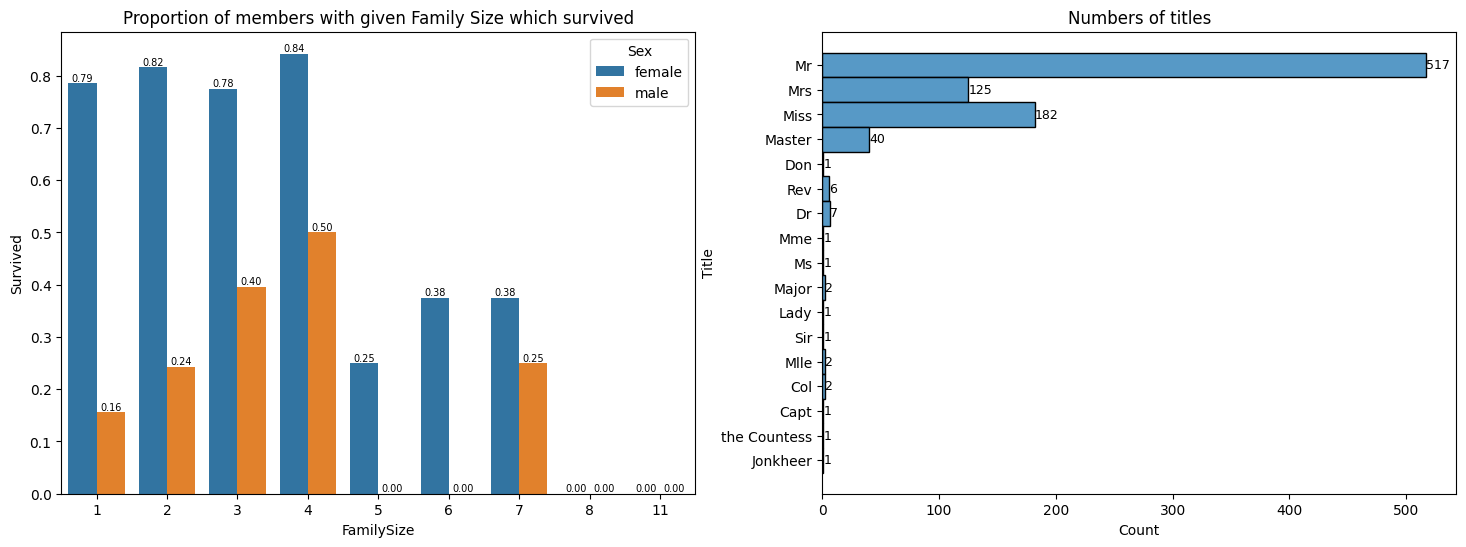

In [343]:
for data in Data: #New variables to analyze
    data["Surname"] = data["Name"].str.split(",", expand=True)[0] #Surname of each passenger. We would like to create a Feature of "Family" to analyze if families died or survived together.
    data["FamilySize"] = data["SibSp"]+data["Parch"]+1 #Family size on board
    data["Title"] = data["Name"].str.split(", ", expand=True)[1].str.split(".", expand=True)[0] #Title of each person (Ex: Mr, Mrs., Miss., etc.)
    data.drop(["Cabin", "Ticket", "PassengerId"],  inplace=True,  axis = 1)
    
#Let plot the data of Family Size and Title:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(18,6))
barplot = sns.barplot(x = "FamilySize", y = "Survived", hue = "Sex", data=data_train, ax=axis1, errorbar=None)
axis1.set_title("Proportion of members with given Family Size which survived")
for container in barplot.containers:
    barplot.bar_label(container, fmt='%1.2f', fontsize=7);
barplot = sns.histplot(data = data_train, y = "Title", ax = axis2);
axis2.set_title("Numbers of titles")
for container in barplot.containers:
    barplot.bar_label(container, fmt='%1i', fontsize=9);

Let try to define a Family feature to group people together. We want to group people who have the same surname, are traveling with family, and they shipped from the same port.

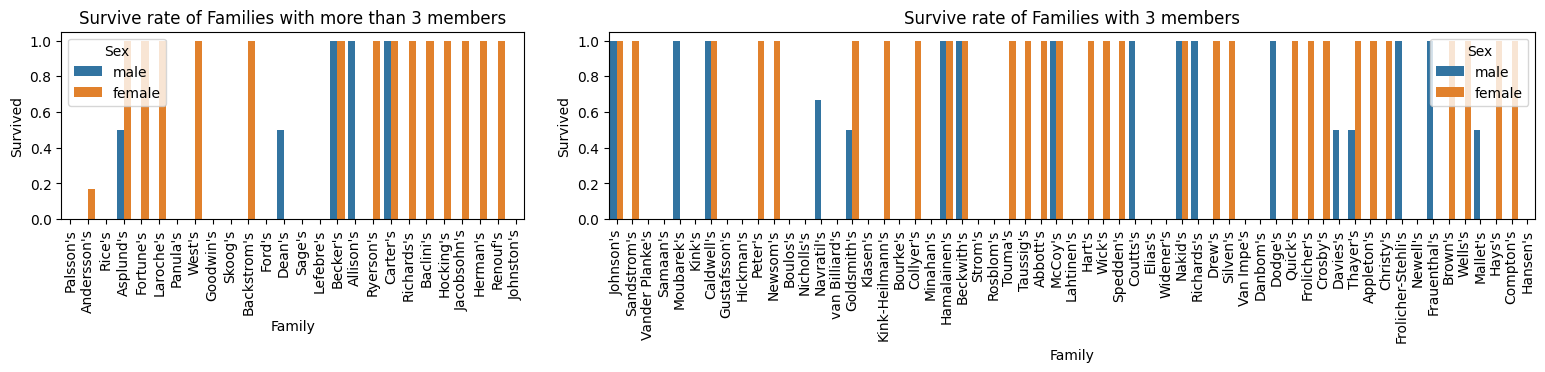

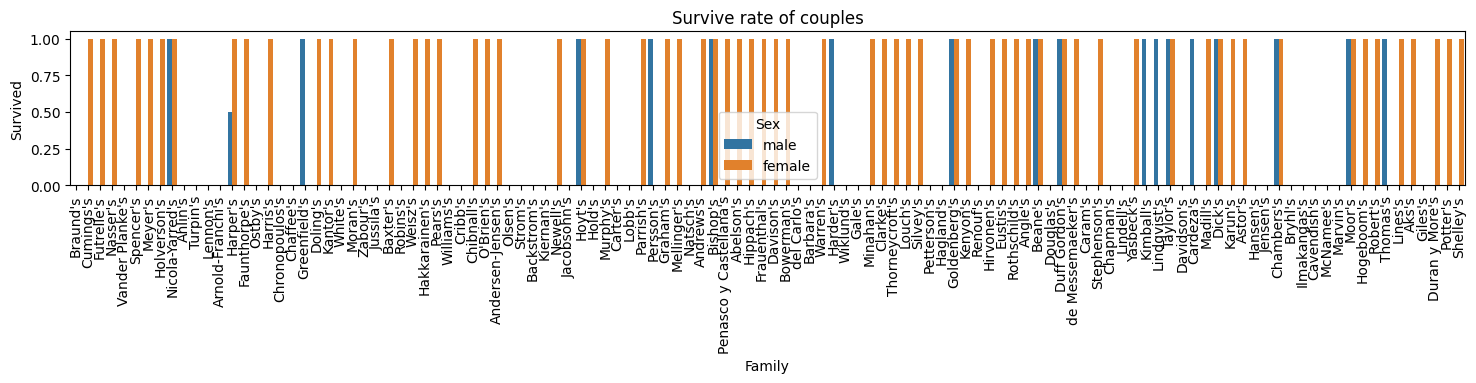

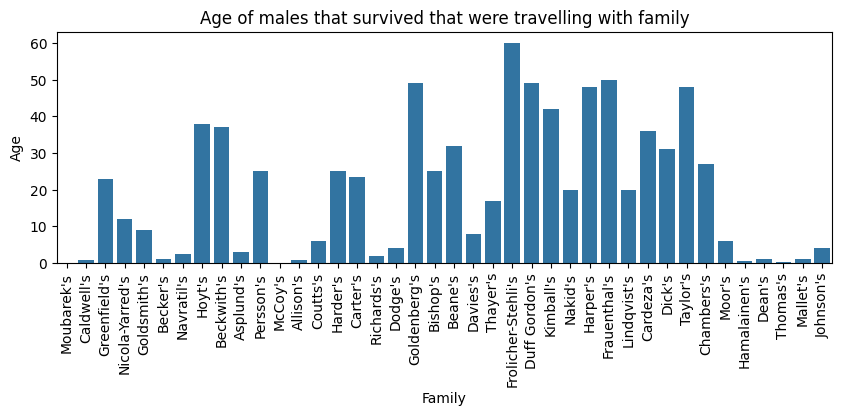

In [344]:
for data in Data:
    data["Family"] = 0
    data["Family"] = data.apply(lambda x: "None" if x["FamilySize"] == 1 else (str(x["Surname"]+"\'s")), axis = 1)
    
fig, (axis1, axis2) = plt.subplots(1,2, figsize=(16,3), width_ratios=[1, 2])
plt.tight_layout(pad = 3.0)
axis1.tick_params(axis='x', rotation=90)
axis1.set_title("Survive rate of Families with more than 3 members")
sns.barplot(x = data_train[(data_train["Family"] != "None") & (data_train["FamilySize"] > 3)]["Family"], y = data_train["Survived"], hue = data_train["Sex"], errorbar = None, ax = axis1);
axis2.set_title("Survive rate of Families with 3 members")
axis2.tick_params(axis='x', rotation=90)
sns.barplot(x = data_train[(data_train["Family"] != "None") & (data_train["FamilySize"] == 3)]["Family"], y = data_train["Survived"], hue = data_train["Sex"], errorbar = None, ax = axis2);

plt.figure(figsize=(18,2))
plt.title("Survive rate of couples")
sns.barplot(x = data_train[(data_train["Family"] != "None") & (data_train["FamilySize"] == 2)]["Family"], y = data_train["Survived"], hue = data_train["Sex"], errorbar = None);
plt.tick_params(axis='x', rotation=90)

plt.figure(figsize=(10,3))
plt.title("Age of males that survived that were travelling with family")
sns.barplot(x = data_train[(data_train["Family"] != "None") & (data_train["Sex"] == "male") & (data_train["Survived"] == 1)]["Family"], y = data_train["Age"], errorbar = None);
plt.tick_params(axis='x', rotation=90)

In almost all families the men died. When the men survived, it does not seems to be a correlation with age. When women died in a family, it is almost always because the whole family died.

Can we say something about the titles?

In [345]:
print("Titles in data_train:", data_train["Title"].value_counts())
print("--------------")
print("Titles in test_train:", data_test["Title"].value_counts())
print("--------------")
print(data_train["Title"].head())

Titles in data_train: Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64
--------------
Titles in test_train: Title
Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: count, dtype: int64
--------------
0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object


Let explain the different titles:

The four most commons refer to: Mr refers to men age 14 or older, while Master refers to a male under age of 14. Mrs refers to a married woman while Miss refers to a non-married woman, without differentiating if its a minor or not. 

For the others: Mlle is Mademoiselle which is an unmarried woman and Mme is Madame which is a married woman. Rev is revered, a religious leader. Dr. is a doctor.  Major, Col, Capt are military titles. Jonkheer is a noble young non-married male. Ms is another abreviation of Miss. Lady and Dona are a married woman. Don and Sir are married men. The Countess is a noble female, which by her age we can assume married.

Let change up the titles which means the same and see if we can obtain some information about their survive rates. 

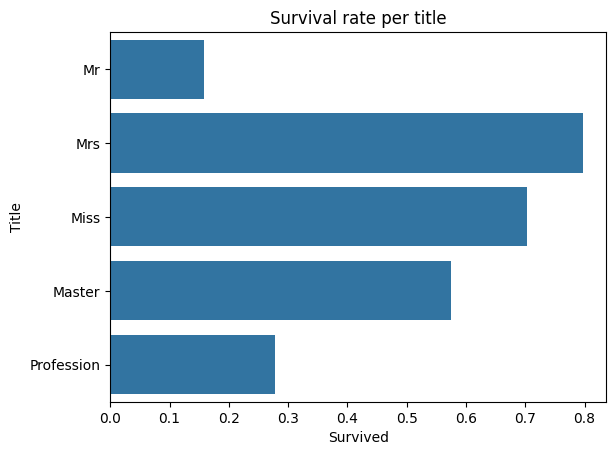

In [346]:
def fix_titles(title):
    if title in ["Mrs", "Mme", "Lady", "Dona", "the Countess"]:
        return "Mrs"
    elif title in ["Miss", "Mlle", "Ms"]:
        return "Miss"
    elif title in ["Mr", "Don", "Sir", "Jonkheer"]:
        return "Mr"
    elif title in ["Master"]:
        return "Master"
    else:
        return "Profession"
for data in Data:
    data["Title"] = data["Title"].map(fix_titles)
plt.figure()
plt.title("Survival rate per title")
sns.barplot(data = data_train, y = "Title", x = "Survived", errorbar = None);

In [347]:
print("Null data on train:")
print(data_train.isnull().sum())
print('-'*25)
print("Null data in test:")
print(data_test.isnull().sum())
print('-'*25)

Null data on train:
Survived        0
Pclass          0
Name            0
Sex             0
Age           177
SibSp           0
Parch           0
Fare            0
Embarked        2
Surname         0
FamilySize      0
Title           0
Family          0
dtype: int64
-------------------------
Null data in test:
Pclass         0
Name           0
Sex            0
Age           86
SibSp          0
Parch          0
Fare           1
Embarked       0
Surname        0
FamilySize     0
Title          0
Family         0
dtype: int64
-------------------------


There are 2 embarked missing on the Train data set. Let see if we can find a correlation between Embarking and Fare/PClass

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Surname,FamilySize,Title,Family
61,1,1,"Icard, Miss. Amelie",female,38.0,0,0,80.0,NaN,Icard,1,Miss,None
829,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,80.0,NaN,Stone,1,Mrs,None


151

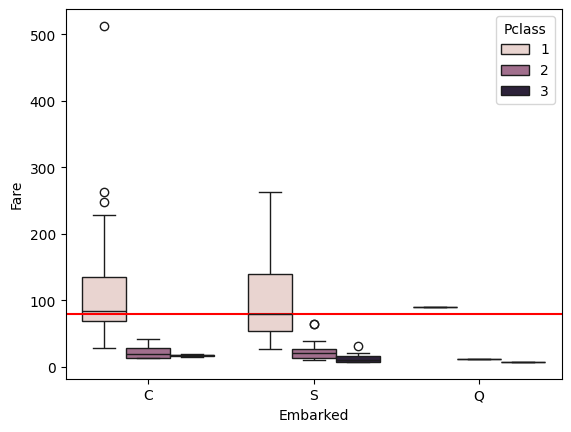

In [348]:
display(data_train[pd.isnull(data_train["Embarked"]) == True])
display(data_train[(data_train["Sex"] == "female") & (data_train["Age"] > 18) & (data_train["Survived"] == 1)].shape[0])
sns.boxplot(data = data_train[(data_train["Sex"] == "female") & (data_train["Age"] > 18) & (data_train["Survived"] == 1)], x = "Embarked", y = "Fare", hue = "Pclass" )
plt.axhline(80, c='r');

It doesnt seems possible to conclude with security on which port they embarked. If we look at the total data, and just restrict ourselves to women of Pclass = 1 and Fare = 80, the best option is to assume that they Embarked in C or S. We will choose S.

In [349]:
data_train["Embarked"].fillna("S", inplace = True)

Now, we will fix the missing Fare value on the test_data. He is a 60.5 years old male of low class (Pclass = 3) which was traveling alone and embarked in Southampton. Thus, lets look at this data:

In [350]:
print(data_test[(data_test["Pclass"] == 3) & (data_test["Embarked"] == "S")].groupby(["Embarked", "Pclass", "Sex"])["Fare"].mean())

Embarked  Pclass  Sex   
S         3       female    16.825610
                  male      12.718872
Name: Fare, dtype: float64


To fix the missing value we will assume that Age is correlated to Pclass, Sex and Title, and in the case of females, Parch. Thus, for each missing value of Age, we will replace it with the mean value of each of these groups. First, we study females. Since the title "Miss" is just a non-married woman, we will use "Parch" to differentiate between a child woman and non-married woman.

In [351]:
print ("Avg age of 'Miss' Title", round(data_train[data_train["Title"] == "Miss"]['Age'].mean()))

print ("Avg age of 'Miss' Title travelling without Parents", round(data_train[(data_train["Title"]=="Miss") & (data_train["Parch"]==0)]['Age'].mean()))

print ("Avg age of 'Miss' Title travelling with Parents", round(data_train[(data_train["Title"]=="Miss") & (data_train["Parch"]!=0)]['Age'].mean()), '\n')

Avg age of 'Miss' Title 22
Avg age of 'Miss' Title travelling without Parents 28
Avg age of 'Miss' Title travelling with Parents 12 



So, it seems that this idea works. Let define a new title to separate between Miss and female Child:

In [352]:
for df in [data_train, data_test]:
    df.loc[(df["Title"]=='Miss') & (df["Parch"]!=0), 'Title']= "FChild"

And now we fix the missing values:

In [353]:
data_test["Fare"].fillna(12.718872 , inplace = True)
grp = data_train.groupby(["Pclass", "Sex", "Title"])["Age"].mean().reset_index()[["Pclass", "Sex", 'Title', "Age"]]
def fill_age(x):
    return grp[(grp.Pclass==x.Pclass) & (grp.Sex==x.Sex) & (grp.Title==x.Title)]['Age'].values[0]
data_train['Age'], data_test['Age'] = [df.apply(lambda x: fill_age(x) if np.isnan(x["Age"]) else x['Age'], axis=1) for df in [data_train, data_test]]

We will fill the respective mean by hand to not overcomplicate things:

In [354]:

print("Null data on train:")
print(data_train.isnull().sum())
print('-'*25)
print("Null data in test:")
print(data_test.isnull().sum())
print('-'*25)

Null data on train:
Survived      0
Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
Surname       0
FamilySize    0
Title         0
Family        0
dtype: int64
-------------------------
Null data in test:
Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
Surname       0
FamilySize    0
Title         0
Family        0
dtype: int64
-------------------------


We note that when people travelled in group, the feature "Fare" is equal for them. Thus, we will fix "Fare" by dividing it by the Family size and then we will segment it. We will also drop "Age", since "Title" give us a very good idea of how society see each person. "Family" and "Surname" seems like a good variable to try to form families, but we will drop it for simplicity. Also "SibSp" and "Parch" since they are already coded on "FamilySize" and "Title". "Name" also was already used and it will be dropped.

In [355]:
data_train['Pers_Fare'], data_test['Pers_Fare'] = [df.apply(lambda x: x["Fare"]/x["FamilySize"], axis=1) for df in [data_train, data_test]]
for data in [data_train, data_test]:
    data.drop(["Fare"], inplace = True, axis = 1)
    data.drop(["Age"], inplace = True,  axis = 1)
    data.drop(["Family"],  inplace=True,  axis = 1)
    data.drop(["SibSp"],  inplace=True,  axis = 1)
    data.drop(["Parch"],  inplace=True,  axis = 1)
    data.drop(["Name"],  inplace=True,  axis = 1)
    data.drop(["Surname"],  inplace=True,  axis = 1)

for data in Data:
    data["FareBin"] = pd.qcut(data["Pers_Fare"], 5) #Since Fare is float, we use quartile separation to map it to 0,1,2,3
    data.drop(["Pers_Fare"], inplace = True, axis = 1)
for data in Data: #Gives each value of the variable a Category to give it a numerical value
    data["Sex_Calc"] = le.fit_transform(data["Sex"])
    data["Embarked_Calc"] = le.fit_transform(data["Embarked"])
    data["FareBin_Calc"] = le.fit_transform(data["FareBin"])
    data["Title_Calc"] = le.fit_transform(data["Title"])

for data in Data:
    data.drop(["Sex"], inplace = True, axis = 1)
    data.drop(["Embarked"], inplace = True,  axis = 1)
    data.drop(["Title"],  inplace=True,  axis = 1)
    data.drop(["FareBin"],  inplace=True,  axis = 1)

print("Data_train shape: ", data_train.shape)
print("Data_test shape: ", data_test.shape)
data_train.head()

Data_train shape:  (891, 7)
Data_test shape:  (418, 6)


,Survived,Pclass,FamilySize,Sex_Calc,Embarked_Calc,FareBin_Calc,Title_Calc
0,0,3,2,1,2,0,3
1,1,1,2,0,0,4,4
2,1,3,1,0,2,2,2
3,1,1,2,0,2,3,4
4,0,3,1,1,2,2,3


Finally, we will apply a Random Forest Regression to predict which people survive.

In [356]:
data_train_y = data_train.pop("Survived")
print(data_train.shape)
print(data_train_y.shape)

(891, 6)
(891,)


In [357]:
RF_Model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0,
                       min_samples_leaf=1, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
X_train, X_test, y_train, y_test = train_test_split(data_train, 
                                                    data_train_y, test_size=0.30)
RF_Model.fit(X_train, y_train)
predictions = RF_Model.predict(X_test)
predictions

array([1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0])

In [358]:
print(f'Test : {RF_Model.score(X_test, y_test):.3f}')
print(f'Train : {RF_Model.score(X_train, y_train):.3f}')

Test : 0.825
Train : 0.857


In [360]:
predictions = RF_Model.predict(data_test)
output = pd.DataFrame({'PassengerId': index_test+892, 'Survived': predictions.flatten()}) #Index was weird, had to add 892 to fix it.
print(output)
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         0
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         1

[418 rows x 2 columns]
Your submission was successfully saved!
